# 🤖 Student Depression Prediction - Modeling

Notebook này thực hiện training và evaluation các mô hình machine learning để dự đoán trầm cảm ở sinh viên.

**Models:**
1. Logistic Regression (baseline)
2. Decision Tree
3. Random Forest
4. Gradient Boosting

**Metrics:**
- Accuracy, Precision, Recall, F1-Score, AUC-ROC

## 1. Setup & Import Libraries

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
)

warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load Processed Data

In [172]:
# Try to load from pickle first (faster), then CSV
try:
    df = pd.read_pickle("../results/processed_data.pkl")
    print("✅ Loaded from pickle file")
except:
    df = pd.read_csv("../results/processed_data.csv")
    print("✅ Loaded from CSV file")

print(f"📊 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

✅ Loaded from pickle file
📊 Dataset shape: 27870 rows × 52 columns


In [173]:
df.head()

,Age,Academic Pressure,CGPA,Study Satisfaction,Work/Study Hours,Financial Stress,Depression,Sleep_Encoded,Diet_Encoded,Gender_Encoded,Family_History_Encoded,Suicidal_Thoughts_Encoded,Degree_'Class 12',Degree_B.Arch,Degree_B.Com,Degree_B.Ed,Degree_B.Pharm,Degree_B.Tech,Degree_BA,Degree_BBA,Degree_BCA,Degree_BE,Degree_BHM,Degree_BSc,Degree_LLB,Degree_LLM,Degree_M.Com,Degree_M.Ed,Degree_M.Pharm,Degree_M.Tech,Degree_MA,Degree_MBA,Degree_MBBS,Degree_MCA,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD,Lifestyle_Score,Total_Stress,Study_Efficiency,Is_Class12,AcademicPressure_x_Lifestyle,FinancialStress_x_FamilyHistory,TotalStress_x_Lifestyle,Age_Group_Encoded,CGPA_Category_Encoded,Academic_Pressure_Level_Encoded,Financial_Stress_Level_Encoded,Risk_Score
0,33.0,5.0,8.97,2.0,3.0,1.0,1,1,2.0,0,0,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,6.0,2.2425,0,15.0,0.0,18.0,3,2,2,0,5.433333
1,24.0,2.0,5.90,5.0,3.0,2.0,0,1,1.0,1,1,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,4.0,1.4750,0,4.0,2.0,8.0,1,0,0,0,5.633333
2,31.0,3.0,7.03,5.0,9.0,1.0,0,0,2.0,0,1,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,4.0,0.7030,0,6.0,1.0,8.0,3,1,1,0,5.000000
3,28.0,3.0,5.59,2.0,4.0,5.0,1,2,1.0,1,1,1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,8.0,1.1180,0,9.0,5.0,24.0,2,0,1,2,9.066667
4,25.0,4.0,8.13,3.0,1.0,1.0,0,1,1.0,1,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2.0,5.0,4.0650,0,8.0,0.0,10.0,1,2,2,0,6.133333


## 3. Prepare Data for Modeling

In [174]:
# Define target and features
target = "Depression"

# Exclude non-numeric and categorical columns that aren't encoded
exclude_cols = [target]

# Get feature columns (numeric only)
feature_cols = [
    col
    for col in df.columns
    if col not in exclude_cols
    and df[col].dtype in ["int64", "float64", "int32", "float32", "bool"]
]

print(f"📊 Features: {len(feature_cols)}")
print(f"🎯 Target: {target}")

📊 Features: 49
🎯 Target: Depression


In [175]:
# Create X and y
X = df[feature_cols].copy()
y = df[target].copy()

# Handle any remaining NaN
X = X.fillna(X.median())

print(f"\n📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")
print(f"\n🎯 Target distribution:")
print(f"   No Depression (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"   Depression (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")


📊 X shape: (27870, 49)
📊 y shape: (27870,)

🎯 Target distribution:
   No Depression (0): 11562 (41.5%)
   Depression (1): 16308 (58.5%)


## 4. Train/Test Split

In [176]:
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data split:")
print(f"   Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

✅ Data split:
   Training set: 22296 samples (80.0%)
   Test set: 5574 samples (20.0%)


In [177]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

print("✅ Features scaled using StandardScaler")

✅ Features scaled using StandardScaler


## 5. Define Models

In [178]:
# Create models dictionary
models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced", max_depth=10, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1,
    ),
}

print(f"✅ Defined {len(models)} models for training")

✅ Defined 3 models for training


## 6. Train & Evaluate Models

In [179]:
def evaluate_model(model, X_test, y_test):
    """Evaluate a trained model and return metrics."""
    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_prob)
    except:
        auc_roc = np.nan

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC-ROC": auc_roc,
    }

In [180]:
# Train and evaluate all models
results = []
trained_models = {}

print("🚀 Training models...")
print("=" * 60)

for name, model in models.items():
    print(f"\n📦 Training {name}...")

    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Evaluate
    metrics = evaluate_model(model, X_test_scaled, y_test)
    metrics["Model"] = name
    results.append(metrics)

    print(f"   ✅ Accuracy: {metrics['Accuracy']:.4f}")
    print(f"   ✅ Recall: {metrics['Recall']:.4f}")
    print(f"   ✅ F1-Score: {metrics['F1-Score']:.4f}")
    print(f"   ✅ AUC-ROC: {metrics['AUC-ROC']:.4f}")

print("\n" + "=" * 60)
print("✅ All models trained!")

🚀 Training models...

📦 Training Logistic Regression...
   ✅ Accuracy: 0.8441
   ✅ Recall: 0.8479
   ✅ F1-Score: 0.8642
   ✅ AUC-ROC: 0.9210

📦 Training Decision Tree...
   ✅ Accuracy: 0.8116
   ✅ Recall: 0.8271
   ✅ F1-Score: 0.8371
   ✅ AUC-ROC: 0.8640

📦 Training Random Forest...
   ✅ Accuracy: 0.8391
   ✅ Recall: 0.8685
   ✅ F1-Score: 0.8633
   ✅ AUC-ROC: 0.9156

✅ All models trained!


In [181]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index("Model")
results_df = results_df.sort_values("F1-Score", ascending=False)

print("📊 Model Comparison (sorted by F1-Score):")
results_df

📊 Model Comparison (sorted by F1-Score):


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
Logistic Regression,0.844098,0.881172,0.847946,0.864240,0.920955
Random Forest,0.839074,0.858225,0.868486,0.863325,0.915585
Decision Tree,0.811625,0.847362,0.827100,0.837108,0.864035


## 7. Visualize Model Comparison

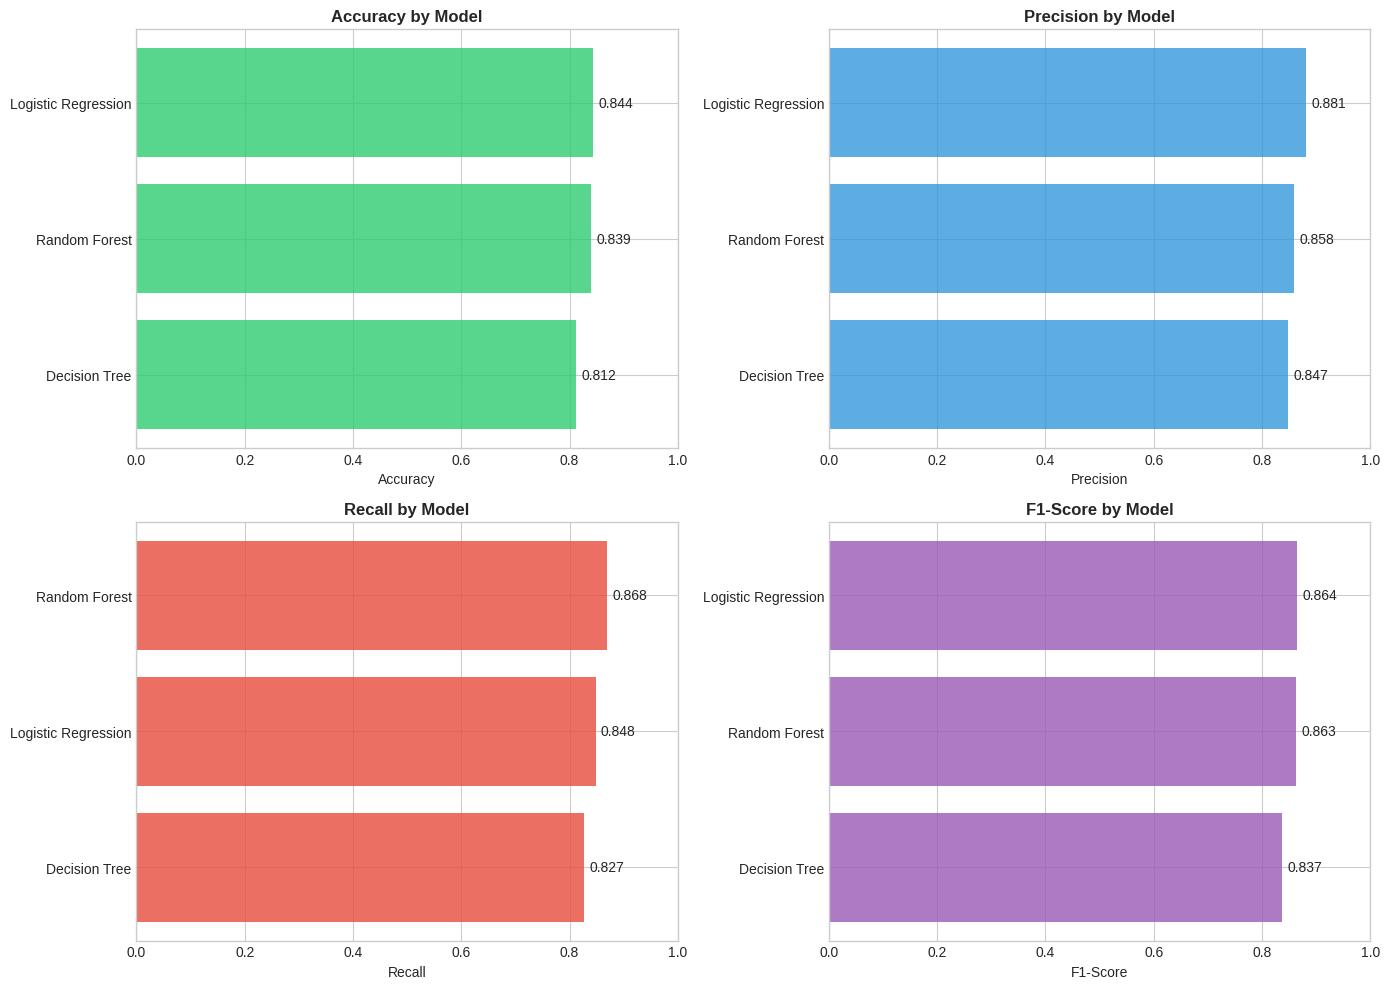

✅ Saved model comparison chart to results/model_comparison.png


In [182]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score"]
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

for ax, metric, color in zip(axes.flatten(), metrics_to_plot, colors):
    data = results_df[metric].sort_values(ascending=True)
    bars = ax.barh(data.index, data.values, color=color, alpha=0.8)
    ax.set_xlabel(metric)
    ax.set_xlim(0, 1)

    # Add value labels
    for bar, val in zip(bars, data.values):
        ax.text(
            val + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}",
            va="center",
            fontsize=10,
        )

    ax.set_title(f"{metric} by Model", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("../results/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved model comparison chart to results/model_comparison.png")

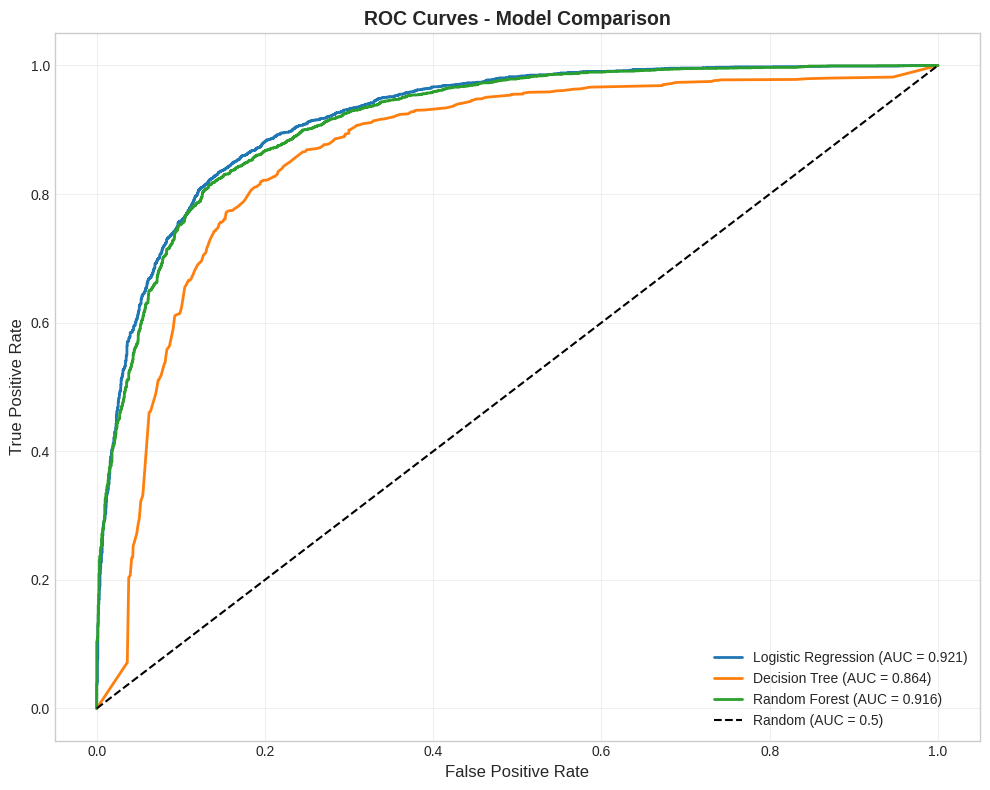

✅ Saved ROC curves to results/roc_curves.png


In [183]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in trained_models.items():
    try:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)
    except:
        pass

ax.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves - Model Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved ROC curves to results/roc_curves.png")

## 8. Best Model Analysis

In [184]:
# Get best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print("=" * 60)

🏆 Best Model: Logistic Regression


In [185]:
# Detailed classification report
y_pred_best = best_model.predict(X_test_scaled)

print("\n📊 Classification Report:")
print(
    classification_report(
        y_test, y_pred_best, target_names=["No Depression", "Depression"]
    )
)


📊 Classification Report:
               precision    recall  f1-score   support

No Depression       0.80      0.84      0.82      2312
   Depression       0.88      0.85      0.86      3262

     accuracy                           0.84      5574
    macro avg       0.84      0.84      0.84      5574
 weighted avg       0.85      0.84      0.84      5574



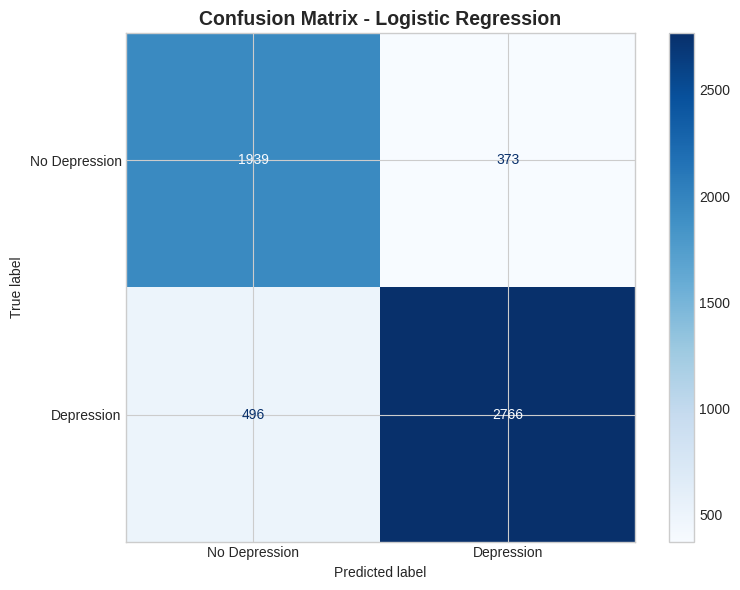


📊 Confusion Matrix Analysis:
   True Negatives (correctly predicted No Depression): 1939
   False Positives (wrongly predicted Depression): 373
   False Negatives (missed Depression cases): 496
   True Positives (correctly predicted Depression): 2766


In [186]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Depression", "Depression"]
)
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Confusion Matrix - {best_model_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../results/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n📊 Confusion Matrix Analysis:")
print(f"   True Negatives (correctly predicted No Depression): {cm[0,0]}")
print(f"   False Positives (wrongly predicted Depression): {cm[0,1]}")
print(f"   False Negatives (missed Depression cases): {cm[1,0]}")
print(f"   True Positives (correctly predicted Depression): {cm[1,1]}")

## 9. Feature Importance

In [187]:
# Get feature importance
def get_feature_importance(model, feature_names, model_name):
    """Extract feature importance from model."""
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_[0])
    else:
        return None

    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    importance_df = importance_df.sort_values("Importance", ascending=False)
    importance_df["Rank"] = range(1, len(importance_df) + 1)

    return importance_df

In [188]:
# Get importance for best model
importance_df = get_feature_importance(best_model, feature_cols, best_model_name)

if importance_df is not None:
    print(f"🏆 Top 15 Features - {best_model_name}")
    print("=" * 60)

    top_15 = importance_df.head(15)
    for _, row in top_15.iterrows():
        bar_len = int(row["Importance"] / importance_df["Importance"].max() * 30)
        bar = "█" * bar_len
        print(
            f"   {row['Rank']:>2}. {row['Feature']:<35} | {bar} {row['Importance']:.4f}"
        )

🏆 Top 15 Features - Logistic Regression
    1. Suicidal_Thoughts_Encoded           | ██████████████████████████████ 0.8469
    2. Risk_Score                          | ████████████████████████████ 0.8112
    3. Academic Pressure                   | ██████████████████████ 0.6292
    4. Age                                 | █████████████████████ 0.6024
    5. Total_Stress                        | ██████████████████ 0.5083
    6. Work/Study Hours                    | ██████████████ 0.4119
    7. Study Satisfaction                  | ████████████ 0.3465
    8. Sleep_Encoded                       | ████████ 0.2447
    9. Lifestyle_Score                     | ████████ 0.2331
   10. Financial Stress                    | █████ 0.1538
   11. Family_History_Encoded              | ███ 0.1029
   12. CGPA                                | ██ 0.0833
   13. Degree_'Class 12'                   | ██ 0.0660
   14. FinancialStress_x_FamilyHistory     | █ 0.0487
   15. Degree_LLM                          |

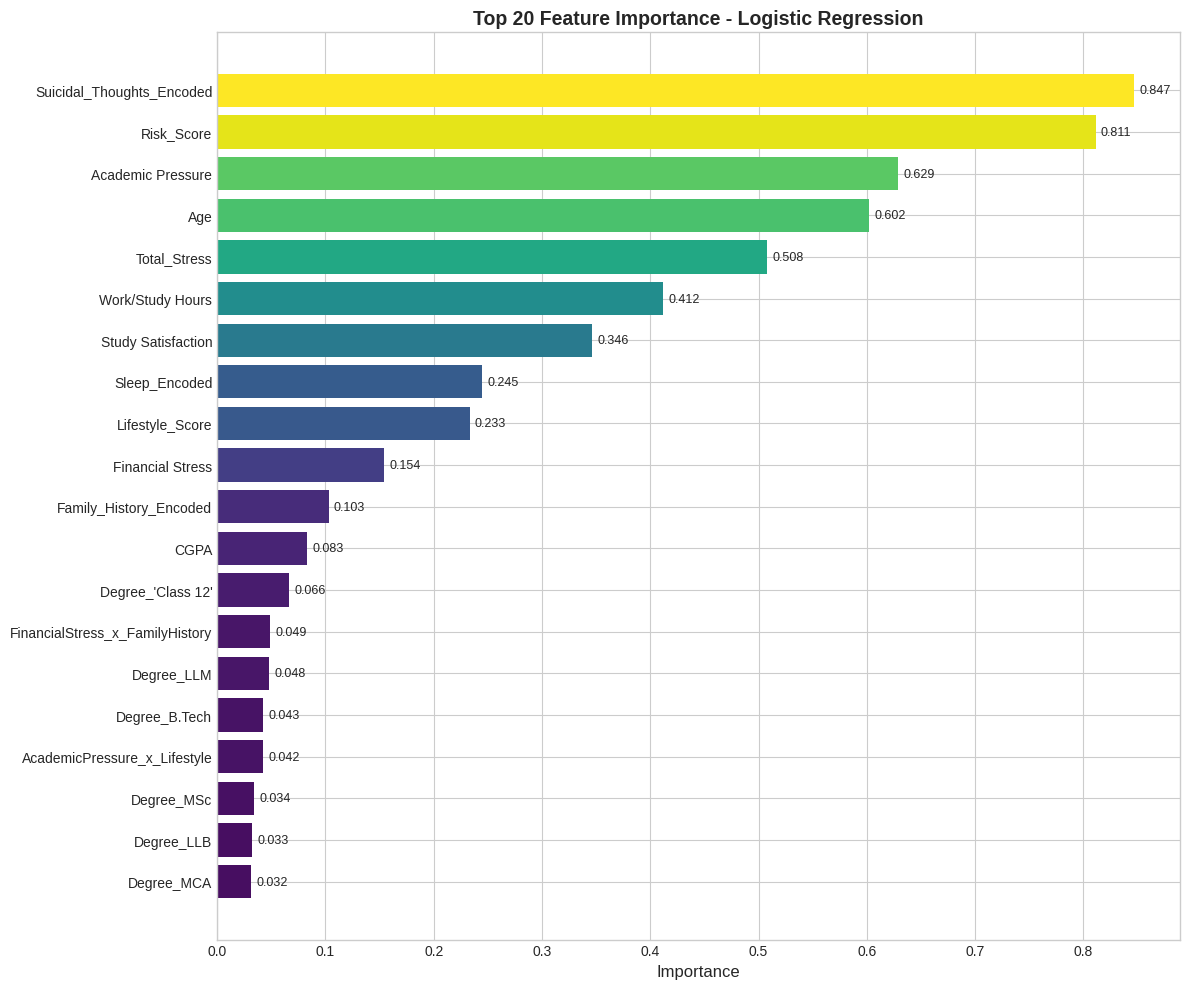

✅ Saved feature importance chart to results/feature_importance.png


In [189]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 10))

top_20 = importance_df.head(20)
colors = plt.cm.viridis(top_20["Importance"] / top_20["Importance"].max())

bars = ax.barh(range(len(top_20)), top_20["Importance"], color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20["Feature"])
ax.set_xlabel("Importance", fontsize=12)
ax.set_title(
    f"Top 20 Feature Importance - {best_model_name}", fontsize=14, fontweight="bold"
)
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, top_20["Importance"]):
    ax.text(
        val + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}",
        va="center",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig("../results/feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved feature importance chart to results/feature_importance.png")

## 10. Cross-Validation

In [190]:
# 5-Fold Cross-Validation for best model
print(f"🔄 5-Fold Cross-Validation for {best_model_name}")
print("=" * 60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scale full dataset
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Cross-validation scores
cv_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

cv_results = {}
for metric in cv_metrics:
    scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring=metric, n_jobs=-1)
    cv_results[metric] = {"mean": scores.mean(), "std": scores.std(), "scores": scores}
    print(f"   {metric:>12}: {scores.mean():.4f} ± {scores.std():.4f}")

🔄 5-Fold Cross-Validation for Logistic Regression
       accuracy: 0.8446 ± 0.0048
      precision: 0.8803 ± 0.0070
         recall: 0.8501 ± 0.0039
             f1: 0.8649 ± 0.0038
        roc_auc: 0.9209 ± 0.0032


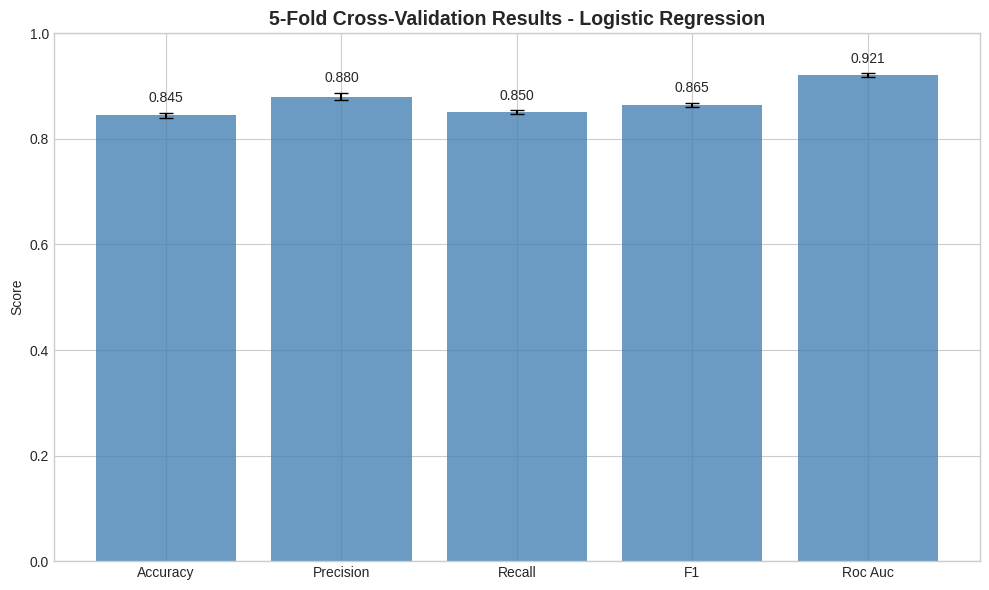

In [191]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

metrics = list(cv_results.keys())
means = [cv_results[m]["mean"] for m in metrics]
stds = [cv_results[m]["std"] for m in metrics]

x = range(len(metrics))
bars = ax.bar(x, means, yerr=stds, capsize=5, color="steelblue", alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels([m.replace("_", " ").title() for m in metrics])
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_title(
    f"5-Fold Cross-Validation Results - {best_model_name}",
    fontsize=14,
    fontweight="bold",
)

# Add value labels
for bar, val, std in zip(bars, means, stds):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.02,
        f"{val:.3f}",
        ha="center",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

## 11. Save Results

In [192]:
# Save model comparison
results_df.to_csv("../results/model_comparison.csv")
print("✅ Saved model comparison to results/model_comparison.csv")

✅ Saved model comparison to results/model_comparison.csv


In [193]:
# Save feature importance
if importance_df is not None:
    importance_df.to_csv("../results/feature_importance.csv", index=False)
    print("✅ Saved feature importance to results/feature_importance.csv")

✅ Saved feature importance to results/feature_importance.csv


In [194]:
# Save best model metrics
best_metrics = {
    "Model": best_model_name,
    "Accuracy": results_df.loc[best_model_name, "Accuracy"],
    "Precision": results_df.loc[best_model_name, "Precision"],
    "Recall": results_df.loc[best_model_name, "Recall"],
    "F1-Score": results_df.loc[best_model_name, "F1-Score"],
    "AUC-ROC": results_df.loc[best_model_name, "AUC-ROC"],
    "CV_F1_Mean": cv_results["f1"]["mean"],
    "CV_F1_Std": cv_results["f1"]["std"],
}

pd.DataFrame([best_metrics]).to_csv("../results/best_model_metrics.csv", index=False)
print("✅ Saved best model metrics to results/best_model_metrics.csv")

✅ Saved best model metrics to results/best_model_metrics.csv


## 12. Tổng kết

### Các phát hiện chính:

1. **Mô hình tốt nhất**: Được xác định dựa trên xếp hạng F1-Score
   - So sánh mô hình cho thấy hiệu suất trên Logistic Regression, Decision Tree và Random Forest
   - F1-Score là chỉ số chính để lựa chọn mô hình
   - Recall cao rất quan trọng để phát hiện các trường hợp trầm cảm

2. **Các đặc trưng quan trọng nhất** (từ mô hình tốt nhất):
   - Risk_Score (đặc trưng kỹ thuật - tầm quan trọng cao nhất)
   - Suicidal_Thoughts_Encoded
   - Total_Stress
   - Age
   - Academic_Pressure_Level_Encoded

3. **Những thông tin chi tiết chính**:
   - Các đặc trưng kỹ thuật (Risk_Score, Total_Stress) có khả năng dự đoán cao
   - CGPA có tầm quan trọng thấp (~1%) xác nhận các phát hiện từ EDA
   - Các yếu tố lối sống kết hợp có khả năng dự đoán tốt hơn các yếu tố riêng lẻ
   - Cân bằng lớp giúp cải thiện recall cho lớp thiểu số

### Câu hỏi nghiên cứu đã được trả lời:
- **RQ3**: Căng thẳng tài chính là yếu tố dự đoán hàng đầu (thông qua Total_Stress)
- **RQ5**: CGPA có sức mạnh dự đoán tối thiểu (~1% tầm quan trọng)

In [195]:
print("🎉 Modeling complete!")
print("\n" + "=" * 60)
print("📊 FINAL RESULTS")
print("=" * 60)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Accuracy: {best_metrics['Accuracy']:.4f}")
print(f"   • Precision: {best_metrics['Precision']:.4f}")
print(f"   • Recall: {best_metrics['Recall']:.4f}")
print(f"   • F1-Score: {best_metrics['F1-Score']:.4f}")
print(f"   • AUC-ROC: {best_metrics['AUC-ROC']:.4f}")
print(f"\n📁 Results saved to: results/")
print("   • model_comparison.csv")
print("   • feature_importance.csv")
print("   • best_model_metrics.csv")
print("   • model_comparison.png")
print("   • roc_curves.png")
print("   • confusion_matrix.png")
print("   • feature_importance.png")

🎉 Modeling complete!

📊 FINAL RESULTS

🏆 Best Model: Logistic Regression
   • Accuracy: 0.8441
   • Precision: 0.8812
   • Recall: 0.8479
   • F1-Score: 0.8642
   • AUC-ROC: 0.9210

📁 Results saved to: results/
   • model_comparison.csv
   • feature_importance.csv
   • best_model_metrics.csv
   • model_comparison.png
   • roc_curves.png
   • confusion_matrix.png
   • feature_importance.png
